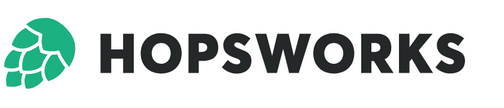

# Create Feature Groups and Backfill Features

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/featurestoreorg/serverless-ml-course/blob/main/src/02-module/1_backfill_cc_feature_groups.ipynb)

**Note**: you may get an error when installing hopsworks on Colab, and it is safe to ignore it.


First, you need to install the hopsworks library.

In [1]:
!pip install -U hopsworks --quiet

## <span style="color:#ff5f27;"> 💽 Loading the Data </span>

The backfill data you will use comes from three different CSV files:

- `credit_cards.csv`: credit card information such as expiration date and provider.
- `transactions.csv`: transaction information such as timestamp, location, and the amount. Importantly, the binary `fraud_label` variable tells us whether a transaction was fraudulent or not.
- `profiles.csv`: credit card user information such as birthdate and city of residence.

You can conceptualize these CSV files as originating from separate data sources.
**All three files have a credit card number column `cc_num` in common (a natural join key).**


In [2]:
import pandas as pd
from datetime import datetime
import hopsworks

In [3]:
url = "https://repo.hops.works/master/hopsworks-tutorials/data/card_fraud_data"
credit_cards_df = pd.read_parquet(url + "/credit_cards.parquet")
credit_cards_df.head(5)

,cc_num,provider,expires
0,4796807885357879,visa,05/23
1,4529266636192966,visa,03/22
2,4922690008243953,visa,02/27
3,4897369589533543,visa,04/22
4,4848518335893425,visa,10/26


In [4]:
credit_cards_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   cc_num    2000 non-null   int64 
 1   provider  2000 non-null   object
 2   expires   2000 non-null   object
dtypes: int64(1), object(2)
memory usage: 47.0+ KB


In [5]:
profiles_df = pd.read_parquet(url + "/profiles.parquet")
profiles_df.head(5)

,name,sex,mail,birthdate,City,Country,cc_num
0,Catherine Zimmerman,F,valenciajason@hotmail.com,1988-09-20,Bryn Mawr-Skyway,US,4796807885357879
1,Michael Williams,M,brettkennedy@yahoo.com,1977-03-01,Gates-North Gates,US,4529266636192966
2,Jessica Krueger,F,marthacruz@hotmail.com,1947-09-10,Greenfield,US,4922690008243953
3,Ruth Harris,F,james11@yahoo.com,1983-12-27,New City,US,4897369589533543
4,Paul Ashley,M,matthew97@hotmail.com,1974-11-10,Peabody,US,4848518335893425


In [6]:
profiles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       2000 non-null   object        
 1   sex        2000 non-null   object        
 2   mail       2000 non-null   object        
 3   birthdate  2000 non-null   datetime64[ns]
 4   City       2000 non-null   object        
 5   Country    2000 non-null   object        
 6   cc_num     2000 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 109.5+ KB


In [7]:
trans_df = pd.read_parquet(url + "/transactions.parquet")
trans_df.head(3)

,tid,datetime,cc_num,category,amount,latitude,longitude,city,country,fraud_label
0,11df919988c134d97bbff2678eb68e22,2022-01-01 00:00:24,4473593503484549,Health/Beauty,62.95,42.30865,-83.48216,Canton,US,0
1,dd0b2d6d4266ccd3bf05bc2ea91cf180,2022-01-01 00:00:56,4272465718946864,Grocery,85.45,33.52253,-117.70755,Laguna Niguel,US,0
2,e627f5d9a9739833bd52d2da51761fc3,2022-01-01 00:02:32,4104216579248948,Domestic Transport,21.63,37.60876,-77.37331,Mechanicsville,US,0


In [8]:
trans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106020 entries, 0 to 106019
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   tid          106020 non-null  object        
 1   datetime     106020 non-null  datetime64[ns]
 2   cc_num       106020 non-null  int64         
 3   category     106020 non-null  object        
 4   amount       106020 non-null  float64       
 5   latitude     106020 non-null  float64       
 6   longitude    106020 non-null  float64       
 7   city         106020 non-null  object        
 8   country      106020 non-null  object        
 9   fraud_label  106020 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 8.1+ MB


## <span style="color:#ff5f27;"> 🛠️ Feature Engineering </span>

Fraudulent transactions can differ from regular ones in many different ways. Typical red flags would for instance be a large transaction volume/frequency in the span of a few hours. It could also be the case that elderly people in particular are targeted by fraudsters. To facilitate model learning you will create additional features based on these patterns. In particular, you will create two types of features:
1. **Features that aggregate data from different data sources**. This could for instance be the age of a customer at the time of a transaction, which combines the `birthdate` feature from `profiles.csv` with the `datetime` feature from `transactions.csv`.
2. **Features that aggregate data from multiple time steps**. An example of this could be the transaction frequency of a credit card in the span of a few hours, which is computed using a window function.

Let's start with the first category.

### Version 2
We have been told by compliance, we are not allowed use the cardholder's age as a feature, so we need to create a version 2 of the feature group without `age_at_transaction`.


In [9]:
from sml import cc_features
import warnings
warnings.filterwarnings('ignore')

fraud_labels = trans_df[["tid", "cc_num", "datetime", "fraud_label"]]
fraud_labels.datetime = fraud_labels.datetime.map(lambda x: cc_features.date_to_timestamp(x))

#trans_df = trans_df.drop(['fraud_label'], axis=1)
# Remove this card-owner age feature in version 2
#trans_df = cc_features.card_owner_age(trans_df, profiles_df)
trans_df = cc_features.expiry_days(trans_df, credit_cards_df)
trans_df = cc_features.activity_level(trans_df, 1)

trans_df

,tid,datetime,cc_num,category,amount,city,country,days_until_card_expires,loc_delta_t_minus_1,time_delta_t_minus_1
0,11df919988c134d97bbff2678eb68e22,1640995224000,4473593503484549,Health/Beauty,62.95,Canton,US,1460.999722,0.221947,1.361921
1,dd0b2d6d4266ccd3bf05bc2ea91cf180,1640995256000,4272465718946864,Grocery,85.45,Laguna Niguel,US,1733.999352,0.103615,1.050301
2,e627f5d9a9739833bd52d2da51761fc3,1640995352000,4104216579248948,Domestic Transport,21.63,Mechanicsville,US,242.998241,0.167885,3.326192
3,6fb3e6beafbb92b8e15827037f603c52,1640995404000,4814447237003448,Health/Beauty,54.71,Nampa,US,150.997639,0.263511,1.709850
4,be0b8acc57bfe126a5a392fd99e6ddd1,1640995435000,4515188652242507,Grocery,59.22,Pottstown,US,515.997280,0.573918,2.961331
...,...,...,...,...,...,...,...,...,...,...
61905,e967e55653d02d9863ece69eb8068368,1651488694000,4581222106011785,Cash Withdrawal,97.49,Carlsbad,US,-62.452477,0.000000,0.000000
62165,b03d8b31c07fff8378edf6f4b15faa6a,1651693447000,4176661673840251,Cash Withdrawal,43.65,Aloha,US,180.177697,0.000000,0.000000
70175,3acb0c896855087ca5e0045ddee1121d,1651790995000,4295947736465426,Cash Withdrawal,100.92,Gainesville,US,1487.048669,0.000000,0.000000
103887,44ae59516c9c0a6d43f75ba1df294e33,1651892153000,4697434187093357,Cash Withdrawal,99.91,Columbia Heights,US,85.877859,0.000000,0.000000


In [10]:
import great_expectations as ge

expectation_suite = ge.core.ExpectationSuite(expectation_suite_name="cc_transactions")

def value_between(expectation_suite, column_name, min, max):
    
    expectation_suite.add_expectation(
      ge.core.ExpectationConfiguration(
      expectation_type="expect_column_values_to_be_between",
      kwargs={"column":column_name, "min_value": min, "max_value": max}) 
    );
    
value_between(expectation_suite, "cc_num", 1000000000000000, 9999999999999999)
value_between(expectation_suite, "days_until_card_expires", -3, 36500) #  10 years 

Next, you will create features that for each credit card aggregate data from multiple time steps.

Yoy will start by computing the distance between consecutive transactions, lets call it `loc_delta`.
Here you will use the [Haversine distance](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html?highlight=haversine#sklearn.metrics.pairwise.haversine_distances) to quantify the distance between two longitude and latitude coordinates.

Before you can create a feature group you need to connect to Hopsworks feature store.

In [11]:
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/398
Connected. Call `.close()` to terminate connection gracefully.


Next lets compute windowed aggregates. Here you will use 4-hour windows, but feel free to experiment with different window lengths by setting `window_len` below to a value of your choice.

In [12]:
window_len = 4
window_aggs_df = cc_features.aggregate_activity_by_hour(trans_df, window_len)
window_aggs_df.tail()

,trans_volume_mstd,trans_volume_mavg,trans_freq,loc_delta_mavg,cc_num,datetime
106015,2420.3075,2420.3075,2420.3075,0.045692,4032019521897961,1648119422000
106016,123.8425,123.8425,123.8425,0.034348,4032019521897961,1648468622000
106017,118.4400,118.4400,118.4400,0.034406,4032019521897961,1648817822000
106018,155.5125,155.5125,155.5125,0.034470,4032019521897961,1649167022000
106019,203.4075,203.4075,203.4075,0.034466,4032019521897961,1649516222000


## <span style="color:#ff5f27;"> 🪄 Creating Feature Groups </span>

A [feature group](https://docs.hopsworks.ai/feature-store-api/latest/generated/feature_group/) can be seen as a collection of conceptually related features. In this case, you will create a feature group for the transaction data and a feature group for the windowed aggregations on the transaction data. Both will have `cc_num` as primary key, which will allow you to join them when creating a dataset in the next tutorial.

Feature groups can also be used to define a namespace for features. For instance, in a real-life setting you would likely want to experiment with different window lengths. In that case, you can create feature groups with identical schema for each window length. 

To create a feature group you need to give it a name and specify a primary key. It is also good to provide a description of the contents of the feature group and a version number, if it is not defined it will automatically be incremented to `1`.

In [13]:
trans_fg_version=3
trans_fg = fs.get_or_create_feature_group(
    name="cc_trans_fraud",
    version=trans_fg_version,
    description="Credit Card transactions",
    primary_key=["cc_num"],
    expectation_suite=expectation_suite,
    event_time="datetime"
)

In [14]:
# trans_fg.save_expectation_suite(expectation_suite=expectation_suite,
#                               validation_ingestion_policy="STRICT")

# If you want to remove the expectation suite, uncomment and run the following line:
# trans_fg.delete_expectation_suite()

A full list of arguments can be found in the [documentation](https://docs.hopsworks.ai/feature-store-api/latest/generated/api/feature_store_api/#create_feature_group).

At this point, you have only specified some metadata for the feature group. It does not store any data or even have a schema defined for the data. To make the feature group persistent you need to populate it with its associated data using the `insert` function.

In [15]:
trans_fg.insert(trans_df, write_options={"wait_for_job" : False})

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/398/fs/335/fg/8560
2022-12-16 11:53:27,054 INFO: 	2 expectation(s) included in expectation_suite.
Validation Report saved successfully, explore a summary at https://c.app.hopsworks.ai:443/p/398/fs/335/fg/8560


Uploading Dataframe: 0.00% |          | Rows 0/106020 | Elapsed Time: 00:00 | Remaining Time: ?

Launching offline feature group backfill job...
Backfill Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/398/jobs/named/cc_trans_fraud_3_offline_fg_backfill/executions


(<hsfs.core.job.Job at 0x7fdd5868fdf0>,
 {
   "meta": {
     "great_expectations_version": "0.14.12",
     "expectation_suite_name": "cc_transactions",
     "run_id": {
       "run_time": "2022-12-16T10:53:27.053653+00:00",
       "run_name": null
     },
     "batch_kwargs": {
       "ge_batch_id": "dea05d56-7d2f-11ed-a7f1-002b67af4ef7"
     },
     "batch_markers": {},
     "batch_parameters": {},
     "validation_time": "20221216T105327.053503Z",
     "expectation_suite_meta": {
       "great_expectations_version": "0.14.12"
     }
   },
   "success": false,
   "evaluation_parameters": {},
   "statistics": {
     "evaluated_expectations": 2,
     "successful_expectations": 1,
     "unsuccessful_expectations": 1,
     "success_percent": 50.0
   },
   "results": [
     {
       "meta": {},
       "exception_info": {
         "raised_exception": false,
         "exception_message": null,
         "exception_traceback": null
       },
       "success": true,
       "expectation_config":

In [16]:
feature_descriptions = [
    {"name": "tid", "description": "Transaction id"},
    {"name": "datetime", "description": "Transaction time"},
    {"name": "cc_num", "description": "Number of the credit card performing the transaction"},
    {"name": "category", "description": "Expense category"},
    {"name": "amount", "description": "Dollar amount of the transaction"},
    {"name": "city", "description": "City in which the transaction was made"},
    {"name": "country", "description": "Country in which the transaction was made"},
#     {"name": "age_at_transaction", "description": "Age of the card holder when the transaction was made"},
    {"name": "days_until_card_expires", "description": "Card validity days left when the transaction was made"},
    {"name": "loc_delta_t_minus_1", "description": "Haversine distance between this transaction location and the previous transaction location from the same card"},
    {"name": "time_delta_t_minus_1", "description": "Time in days between this transaction and the previous transaction location from the same card"},
]

for desc in feature_descriptions: 
    trans_fg.update_feature_description(desc["name"], desc["description"])

At the creation of the feature group, you will be prompted with an URL that will directly link to it; there you will be able to explore some of the aspects of your newly created feature group.

[//]: <> (insert GIF here)

You can move on and do the same thing for the feature group with our windows aggregation.

In [17]:
window_aggs_fg = fs.get_or_create_feature_group(
    name=f"cc_trans_fraud_{window_len}h",
    version=2,
    description=f"Counts of the number of credit card transactions over {window_len} hour windows.",
    primary_key=["cc_num"],
    event_time="datetime"
)

In [18]:
window_aggs_fg.insert(window_aggs_df, write_options={"wait_for_job" : False})

RestAPIError: Metadata operation error: (url: https://c.app.hopsworks.ai/hopsworks-api/api/project/398/featurestores/335/featuregroups). Server response: 
HTTP code: 500, HTTP reason: Internal Server Error, error code: 270001, error msg: Could not create feature group and corresponding Hive table, user msg: Error creating feature group table in the Hive Metastore: Table hive.dowlingj_featurestore.cc_trans_fraud_4h_1 already exists

In [19]:
feature_descriptions = [
    {"name": "datetime", "description": "Transaction time"},
    {"name": "cc_num", "description": "Number of the credit card performing the transaction"},
    {"name": "loc_delta_mavg", "description": "Moving average of location difference between consecutive transactions from the same card"},
    {"name": "trans_freq", "description": "Moving average of transaction frequency from the same card"},
    {"name": "trans_volume_mavg", "description": "Moving average of transaction volume from the same card"},
    {"name": "trans_volume_mstd", "description": "Moving standard deviation of transaction volume from the same card"},
]

for desc in feature_descriptions: 
    window_aggs_fg.update_feature_description(desc["name"], desc["description"])

TypeError: 'NoneType' object is not iterable

In [ ]:
trans_label_fg = fs.get_or_create_feature_group(
    name="transactions_fraud_label",
    version=2,
    description="CC transactions that have been flagged as fraud",
    primary_key=['cc_num'],
    event_time='datetime'
)

trans_label_fg.insert(fraud_labels, write_options={"wait_for_job" : False})

In [ ]:
feature_descriptions = [
    {"name": "tid", "description": "Transaction id"},
    {"name": "cc_num", "description": "Number of the credit card performing the transaction"},    
    {"name": "datetime", "description": "Transaction time"},
    {"name": "fraud_label", "description": "Whether the transaction was fraudulent or not"},
]
for desc in feature_descriptions: 
    trans_label_fg.update_feature_description(desc["name"], desc["description"])

Both feature groups are now accessible and searchable in the UI

## <span style="color:#ff5f27;">⏭️ **Next:** Synthetic Data Feature Pipeline </span>

In the following notebook you will use create synthetic data that will be used to create features that are written to the  feature groups you created here.